# Assignment 13: Phát hiện bàn tay (hand detection) sử dụng đặc trưng Haar-like và Adaboost 

Trong bài tập này ta sẽ thực hành bài toán phát hiện bàn tay với bộ dữ liệu L3i-MICA sử dụng đặc trưng Haar-like và Adaboost. Bài tập yêu cầu bạn thực hành các bước sau:
- Chuẩn bị dự liệu
- Huấn luyện mô hình
- Sử dụng mô hình đã huấn luyện để phát hiện bàn tay
- Đánh giá hiệu năng của mô hình đã huấn luyện

In [1]:
import os 
import cv2
import numpy as np

## Bài tập 1: Chuẩn bị dữ liệu

### Bài tập 1.1: Chuẩn bị dữ liệu thô

Bộ dữ liệu L3i-MICA được thu thập từ 12 người khác nhau, được chia thành 2 tập Train/Test lần lượt lưu trong các thư mục Train/Test. Bộ dữ liệu gồm nhiều video, mỗi video có độ dài khoảng 3 giây với frame rate là 30. Từ mỗi video này ta cần trích ra một vài frame để làm dữ liệu huấn luyện. Ngoài ra, đi kèm với bộ dữ liệu này là một tệp 'info_train_whole_hand.txt' và 'info_test_whole_hand.txt' để lưu trữ nhãn dữ liệu. Hãy quan sát một vài dòng trong các tệp này:

In [2]:
!head info_train_whole_hand.txt

Ta có thể thấy mỗi dòng trong các tệp này gồm có 6 trường, phân tách nhau bởi kí tự Tab ('\t'), lần lượt là: Đường dẫn tương đối đến video, kiểu hình tay (có 21 kiểu hình), hoành độ góc trên trái, tung độ góc trên trái, chiều dài, chiều rộng của hình chữ nhật chứa bàn tay trong video tương ứng. 

Để có thể huấn luyện được mô hình HaarCascade sử dụng framework OpenCV, ta cần có tập các ảnh huấn luyện và tệp nhãn tương ứng của các ảnh này, tệp nhãn này (được gọi là annotations file) gồm nhiều dòng, mỗi dòng có cấu trúc như sau:

[đường dẫn đến ảnh] [số lượng nhãn: n] [x1, y1, w1, h1] ... [xn, yn, wn, hn]

trường thứ nhất là đường dẫn đến ảnh, trường thứ hai chứa số lượng đối tượng có trong ảnh (trong bộ dữ liệu ta sử dụng thì luôn chỉ có 1 đối tượng trong ảnh), n trường tiếp theo mỗi trường miêu tả một hình chữ nhật chứa đối tượng tương tự như tệp ta vừa quan sát ở trên. 


Hãy hoàn thành hàm extract_image_from_video() dưới đây để xây dựng tập dữ liệu cho mô hình, nhận đầu vào là:
- info_file: Đường dẫn đến file chứa nhãn dữ liệu của tập L3i_MICA.
- image_save_path: Đường dẫn lưu trữ ảnh lấy từ các video của tập dữ liệu L3i-MICA.
- ann_path: Đường dẫn đến annotation file sẽ xây dựng.
- gesture_list: List những kiểu hình tay ta sẽ sử dụng. Mặc định gesture_list = None để lấy toàn bộ video.
- frames_per_capture: Khoảng cách frame mỗi lần ta lấy ảnh từ video.

In [3]:
def extract_image_from_video(info_file, image_save_path, ann_path, gesture_list=None, frames_per_capture=10):
    
    # Tạo thư mục chứa ảnh nếu không tồn tại
    if not os.path.isdir(image_save_path):
        os.makedirs(image_save_path)
        
    # Mở tệp info để đọc
    with open(info_file, 'r') as f:
        # Mở tệp annotation để ghi
        with open(os.path.join(ann_path), 'w') as g:
            # Biến đếm số lượng video, có thể sử dụng để đặt tên ảnh
            number_of_video = 0
            
            # Xét từng dòng trong file info
            for line in f:
                # Một vài bước xử lý dữ liệu 
                line = line.replace('\r\n', '')
                if os.name == 'posix':
                    line = line.replace('\\', '/')
                
                # TODO: Lấy thông tin từng trường trong dòng line, lưu ra các biến tương ứng
                video_path, gesture_type, x, y, w, h = None, None, None, None, None, None 
                
                # YOUR CODE HERE #
                line = line.split('\t')
                video_path = line[0]
                gesture_type, x, y, w, h = [int(x) for x in line[1:]]
                # END YOUR CODE #
                # print(video_path, gesture_type, x, y, w, h)
                
                # Kiểm tra gesture_type
                if (gesture_list is None) or (gesture_type in gesture_list):
                    # Tăng số lượng video 
                    number_of_video += 1
                    
                    # Biến đếm số lượng frame
                    count = -1
                    
                    # TODO: Sử dụng OpenCV đọc video từ đường dẫn video_path. Với mỗi video, xét từng frame
                    # nếu chỉ số frame hiện tại chia hết cho frames_per_capture thì lưu lại frame này với
                    # tên theo mẫu: [number_of_video]_[count].jpg (ví dụ: 1_0.jpg) và ghi một dòng vào file 
                    # annotation 
                    
                    # YOUR CODE HERE #
                    cap = cv2.VideoCapture(video_path)
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                        count += 1
                        if count % frames_per_capture == 0:
                            file_name = os.path.join(image_save_path, (str(number_of_video) + '_' + str(count) + '.jpg'))
                            cv2.imwrite(file_name, frame)
                            g.write("%s %d %d %d %d %d\n" % (os.path.abspath(file_name), 1, x, y, w, h))
                    # END YOUR CODE #

In [4]:
extract_image_from_video(info_file='info_train_whole_hand.txt', 
                         ann_path='train_ann.txt', 
                         image_save_path='Image/Train', 
                         gesture_list=[1, 2, 3],
                         frames_per_capture=20)

In [5]:
extract_image_from_video(info_file='info_test_whole_hand.txt', 
                         ann_path='test_ann.txt', 
                         image_save_path='Image/Test', 
                         gesture_list=[1, 2, 3],
                         frames_per_capture=20)

Kết quả ta thu được thư mục chứa các ảnh và file annotaion:

In [6]:
!head train_ann.txt

/home/lam/ComputerVision/Homework/L8/Image/Train/1_0.jpg 1 77 92 56 42
/home/lam/ComputerVision/Homework/L8/Image/Train/1_20.jpg 1 77 92 56 42
/home/lam/ComputerVision/Homework/L8/Image/Train/1_40.jpg 1 77 92 56 42
/home/lam/ComputerVision/Homework/L8/Image/Train/1_60.jpg 1 77 92 56 42
/home/lam/ComputerVision/Homework/L8/Image/Train/1_80.jpg 1 77 92 56 42
/home/lam/ComputerVision/Homework/L8/Image/Train/2_0.jpg 1 50 98 62 39
/home/lam/ComputerVision/Homework/L8/Image/Train/2_20.jpg 1 50 98 62 39
/home/lam/ComputerVision/Homework/L8/Image/Train/2_40.jpg 1 50 98 62 39
/home/lam/ComputerVision/Homework/L8/Image/Train/2_60.jpg 1 50 98 62 39
/home/lam/ComputerVision/Homework/L8/Image/Train/2_80.jpg 1 50 98 62 39


### Bài tập 1.2 (tham khảo): Xây dựng dữ liệu huấn luyện theo chuẩn của OpenCV
Để huấn luyện mô hình HaarCascade ta cần có tập dữ liệu Positive và Negative, ta sẽ lần lượt xây dựng các tập này theo đúng mẫu của OpenCV

* Chuẩn bị tập Positive: Ta sẽ sử dụng annotation file đã xây dựng ở bên trên và tool opencv_creatsamples của OpenCV:

In [7]:
!opencv_createsamples -vec training.vec -info train_ann.txt -w 32 -h 24 -num 3000

/bin/bash: opencv_createsamples: command not found


* Chuẩn bị tập Negative: Tập ảnh negative được đặt trong thư mục Negative. Ta cần xây dựng file negative.txt gồm nhiều dòng, mỗi dòng chứa đường dẫn đến ảnh negative:

In [8]:
with open('negative.txt', 'w') as f:
    for file_name in os.listdir('data/Negative'):
        f.write(os.path.join('data/Negative', file_name))
        f.write('\n')

In [9]:
!head negative.txt

data/Negative/9502.bmp
data/Negative/9110.bmp
data/Negative/9946.bmp
data/Negative/9739.bmp
data/Negative/9632.bmp
data/Negative/8903.bmp
data/Negative/9196.bmp
data/Negative/9292.bmp
data/Negative/8764.bmp
data/Negative/8686.bmp


## Bài tập 2 (hướng dẫn): Huấn luyện mô hình

Trong bài tập này ta sẽ sử dụng công cụ opencv_traincascade để huấn luyện mô hình phát hiện bàn tay. Bạn có thể tham khảo các tham số của các công cụ này tại đường link: https://docs.opencv.org/3.3.0/dc/d88/tutorial_traincascade.html

In [10]:
!opencv_traincascade -vec training.vec -bg negative.txt -w 32 -h 24 -numStages 10 -data ./haarcascades/ -maxFalseAlarmRate 0.3 -numPos 200 -numNeg 400

/bin/bash: opencv_traincascade: command not found


## Bài tập 3: Sử dụng mô hình đã huấn luyện để detect trên ảnh thực tế

Trong bài tập này, ta sẽ sử dụng mô hình đã huấn luyện để thử tìm kiếm bàn tay trên ảnh trong tập dữ liệu test. 

[[232  61  58  58]]


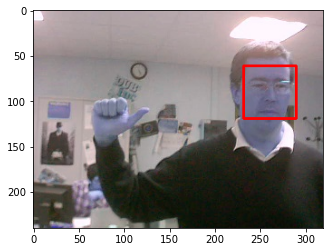

In [11]:
import matplotlib.pyplot as plt

our_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
img = cv2.imread('./Image/Test/1_0.jpg')

hands = our_cascade.detectMultiScale(img, 1.3, 2)
print(hands)
for (x, y, w, h) in hands:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(img)
plt.show()


## Bài tập 4: Đánh giá hiệu năng mô hình

Trong bài tập này ta sẽ lập trình các hàm tính các giá trị Precision và Recall để đánh giá độ chính xác của mô hình detection. 

Như chúng ta đã biết, một detected box được coi là dự đoán đúng nếu độ đo IoU của nó với một ground truth box nào đó lớn hơn một ngưỡng cho trước (thương là 0.5). Hãy lập trình hàm IoU(box1, box2) nhận vào 2 hình chữ nhật box1, box2 được đặc trưng bởi 4 tham số x, y, w, h như ta quy định ở các bài tập trên, kết quả trả về độ đo IoU giữa hai hình chữ nhật đầu vào:

In [12]:
def IoU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    iou = 0.0
    #### YOUR CODE HERE ####
    u1 = x1 + w1 - 1
    v1 = y1 + h1 - 1
    u2 = x2 + w2 - 1
    v2 = y2 + h2 - 1
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(u1, u2)
    yB = min(v1, v2)
    #print(x1, y1, u1, v1)
    #print(x2, y2, u2, v2)
    #print(xA, yA, xB, yB)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    #print(interArea)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = w1 * h1
    boxBArea = w2 * h2

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    #### END YOUR CODE #####
    return iou

Thực hiện detect trên ảnh test: Ta sẽ thực hiện load ảnh đã chuẩn bị trong file test_ann.txt. Để đánh giá hiệu năng của mô hình ta sẽ sử dụng các độ đo: Precision, Recall và F1-score, nhắc lại các công thức tính các độ đo:

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1-score = 2 * Precision * Recall / (Precision + Recall)

Trong đó:

TP (True Positive): Một detected box được tính là TP nếu IoU giữa nó và 1 truth box nào đó lớn hơn một ngưỡng định nghĩa trước.

FP (False Positive): Một detected box được tính là FP nếu không tồn tại 1 truth box nào mà IoU giữa 2 box lớn hơn một ngưỡng định nghĩa trước.

FN (False Negative): Một truth box mà không tồn tài một detected box nào sao cho IoU giữa 2 box lớn hơn một ngưỡng định nghĩa trước được tính là một FN.

In [13]:
TP = 0
FP = 0
FN = 0

our_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

threshold = 0.3
with open('test_ann.txt', 'r') as f:
    for line in f:
        line = line.split(' ')
        image_path = line[0]
        truth_box = [int(line[i]) for i in range(2, 6)]
        
        img = cv2.imread(image_path)
        
        hands = our_cascade.detectMultiScale(img, 1.3, 0)
        
        if len(hands) == 0:
            FN += 1
            continue
        
        true_detect = 0
        for detection in hands:
            t = IoU(detection, truth_box)
            if t >= threshold:
                true_detect += 1
        TP += true_detect
        FP += len(hands) - true_detect

precision = 1.0 * TP / (TP + FP)
recall = 1.0 * TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(precision)
print(recall)
print(f1)

0.004279131007241606
0.9285714285714286
0.008519003931847968


# BÀI TẬP VỀ NHÀ

1. Tìm hiểu và thử nghiệm các mô hình Cascade có sẵn trong OpenCV.

2. Sử dụng thuật toán đã học, xây dựng mô hình phát hiện mặt người sử dụng bộ dữ liệu WIDER FACE:

http://shuoyang1213.me/WIDERFACE/